In [1]:
# Import Packages 
import torch 
from torch import nn

import pytesseract
import cv2

import argparse
import numpy as np
#import opencv_wrapper as cvw
from skimage.filters import threshold_local
import json

import random
from string import ascii_uppercase, digits, punctuation
import colorama
import regex

import matplotlib.pyplot as plt

get_info function is from https://gist.github.com/ttchengab/293fc3ca782b20cf9b05c33f13583338

In [2]:
"""
get_info() function reads the image using openCV and performs thresholding, dilation, noise removal, and
contouring to finally retrieve bounding boxes from the contour.
Below are some of the additional available functions from openCV for preprocessing:
Median filter: median filter blurs out noises by taking the medium from a set of pixels
cv2.medianBlur()
Dilation and erosion: dilation adds pixels to boundaries of pixels, erosion removes it
cv2.dilate()
cv2.erode()
cv2.opening() #This is an erosion followed by a dilation
"""

def get_info(path):
    font     = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    fontColor  = (255,0,0)
    lineType = 1

    #Threshold
    image = cv2.imread(path)

    height,width,channel = image.shape
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    T = threshold_local(gray, 15, offset = 6, method = "gaussian") # generic, mean, median, gaussian
    thresh = (gray > T).astype("uint8") * 255
    thresh = ~thresh

    #Dilation
    kernel =np.ones((1,1), np.uint8)
    ero = cv2.erode(thresh, kernel, iterations= 1)
    img_dilation = cv2.dilate(ero, kernel, iterations=1)

    # Remove noise
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_dilation, None, None, None, 8, cv2.CV_32S)
    sizes = stats[1:, -1] #get CC_STAT_AREA component
    final = np.zeros((labels.shape), np.uint8)
    for i in range(0, nlabels - 1):
        if sizes[i] >= 10:   #filter small dotted regions
            final[labels == i + 1] = 255

    #Find contours
    kern = np.ones((5,15), np.uint8)
    img_dilation = cv2.dilate(final, kern, iterations = 1)
    contours, hierarchy = cv2.findContours(img_dilation, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Map contours to bounding rectangles, using bounding_rect property
    rects = map(lambda c: cv2.boundingRect(c), contours)
    # Sort rects by top-left x (rect.x == rect.tl.x)
    sorted_rects = sorted(rects, key =lambda r: r[0])
    sorted_rects = sorted(sorted_rects, key =lambda r: r[1])

    etfo=''
    for rect in sorted_rects:
        x,y,w,h = rect
        if(w<20 or h<20):
            continue
        temp = image[y:y+h, x:x+w]
        temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        hi = pytesseract.image_to_data(temp, config=r'--psm 6')
        hi = hi.split()
        ind = 22
        while(True):
            if (ind>len(hi)):
                break
            hi_float = float(hi[ind])
            hi[ind]= int(hi_float)
            if(int(hi[ind])==-1):
                ind+=11
            else:
                etfo=etfo+hi[ind+1]
                etfo=etfo+" "
                x+=len(hi[ind+1])*20
                ind+=12
        etfo=etfo+'\n'
    return etfo

In [3]:
result = get_info('data/tj2024.png')

In [4]:
type(result)

str

In [5]:
print(result)


T 
RA 
D 
E 
§ 
R 
> 
- Lg 
WJ 
O 
rF hCU® a 
72) 
Washington apolis, MN tore #0725 
Ave 
S 
101 
suite 55415 Cavan 
te 
Minneapo 
is 
Store 
612-339. 
10 
OPEN 
g 
SOOAM 
Js QOPM 
10 
DAILY 
SALE 
TRANSACTION 
ot 49 14 
$3 
Biv 
| JASMINE FROM “3LLON WHULE 
RICE 
$? 
a 
H 
MILK 
$ | 
ft 
OR. 
AGH 
BANANA 
$0.29 

6 
99 
“f 
$3. $4. $0. 
ANCIENT 
BREAD 
GRAIN 
SE 
y 
& 
- 7 
49 
CLUSTERS 
RATSIN 
BRAN 
ORG 
A 
05 
BAG 
FEE 
BAG 
05 
$0 
FEEL. 

items 
in 
1 
jon: 
1? 
iausact 
jance 
ae 16.80 
Ra 
to 
pay 
AMEX $16.80 1p CONTACTLESS — Ode: Sie MID; #4#44427013 = TID; = ##KGO00- TOTAL: PURCHASE ho \ 4 816.80 No Cardholder Verification = _ Please retain for your records: STORE TILL TRANS. DATE 0725 85 142251 06-05-24 19:56 i traderjoes.com 
AMEX 




Shia Gee tema 





PAYMENT 
yeast so 
7 


OS 


i 





mf with ‘UD: 



=r Si 
KE 



es eet 
re) posers | Bees, 3 
AE ad 
I 

) Los) See 
ae 

oes 

ee 




rt 

aS 


pee 
F ia 







tt 
acme 


as 


gH 
oe 


ae: 
icp anaes oe Oe 


In [9]:
#0. Load the image and show some basic information
img = cv2.imread('data/tj2024.png')
height,width,channel = img.shape
print(height,width,channel)

3200 1336 3


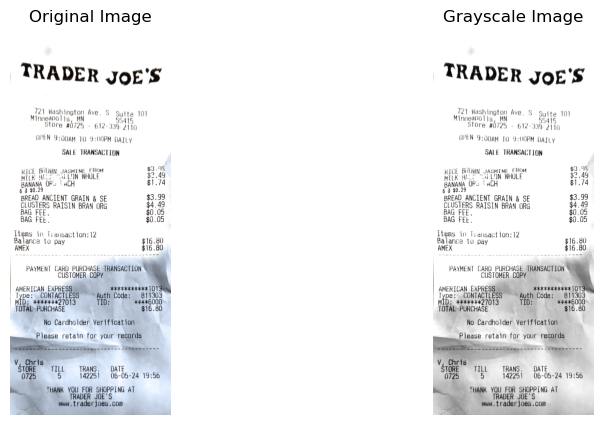

In [11]:
#1. Convert the image to grayscale
grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Show the original image and the greyed image
fig, axs = plt.subplots(1,2, figsize=(10,5))
# Display the original image in the first subplot
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
axs[0].set_title('Original Image')
axs[0].axis('off')  # Hide axes ticks

# Display the grayscale image in the second subplot
axs[1].imshow(grey_img, cmap='gray')
axs[1].set_title('Grayscale Image')
axs[1].axis('off')  # Hide axes ticks

plt.show()

In [13]:
# 2. applies a local threshold to an image, meaning that for each pixel, its threshold value is determined based on the pixel
block_size = 35 # size of the local region to calculate the threshold
T = threshold_local(grey_img, block_size, offset = 6, method = "gaussian") # generic, mean, median, gaussian

In [23]:
print(f"Comparison RGB: {img[1,1]}, grayscale {grey_img[1,1]}, threshold: {T[1,1]}")

Comparison RGB: [255 233 218], grayscale 231, threshold: 243.80031158357335


In [30]:
# For all the values in the image, if the value is greater than the threshold, set it to 255, else set it to 0
thresh_img = (grey_img > T).astype("uint8") * 255
thresh_img = ~thresh_img # Reverse the image to get the text in white and background in black


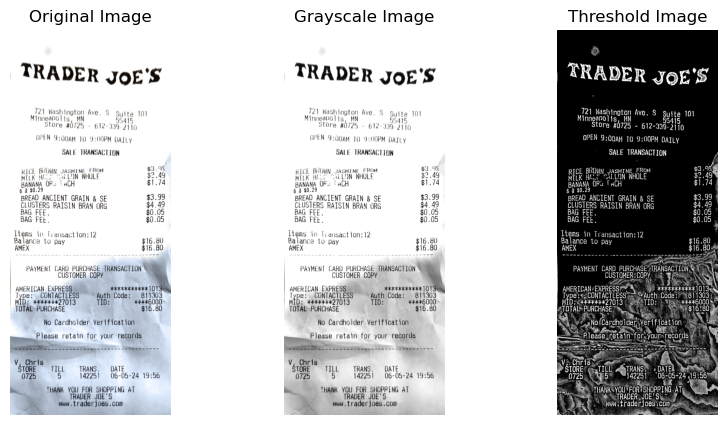

In [31]:
# Show the original image and the greyed image
fig, axs = plt.subplots(1,3, figsize=(10,5))
# Display the original image in the first subplot
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
axs[0].set_title('Original Image')
axs[0].axis('off')  # Hide axes ticks

# Display the grayscale image in the second subplot
axs[1].imshow(grey_img, cmap='gray')
axs[1].set_title('Grayscale Image')
axs[1].axis('off')  # Hide axes ticks

# Display the Threshold image in the third subplot
axs[2].imshow(thresh_img, cmap='gray')
axs[2].set_title('Threshold Image')
axs[2].axis('off')  # Hide axes ticks

plt.show()

Next step involves reducing the brightness of pixels based on the characteristics of the kernel. This operation is primarily used for reducing noise, separating individual elements, and shrinking objects in a binary or grayscale image.

In [40]:
#3. Dilation
kernel =np.ones((1,1), np.uint8)
erode_img = cv2.erode(thresh_img, kernel, iterations= 1)
print(f"Difference between erode and threshold: {np.sum(np.sum(erode_img - thresh_img))}")
#img_dilation = cv2.dilate(erode_img, kernel, iterations=1)

Difference between erode and threshold: 0


In [41]:
dilation_img = cv2.dilate(erode_img, kernel, iterations=1)
print(f"Difference between dilation and threshold: {np.sum(np.sum(erode_img - dilation_img))}")


Difference between dilation and threshold: 0


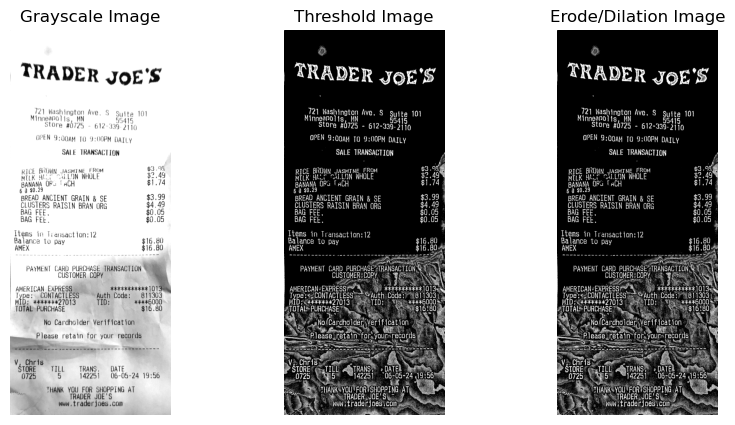

In [42]:
# Show the greyed image, the threshold image and the erode image
fig, axs = plt.subplots(1,3, figsize=(10,5))

# Display the grayscale image in the first subplot
axs[0].imshow(grey_img, cmap='gray')
axs[0].set_title('Grayscale Image')
axs[0].axis('off')  # Hide axes ticks

# Display the Threshold image in the second subplot
axs[1].imshow(thresh_img, cmap='gray')
axs[1].set_title('Threshold Image')
axs[1].axis('off')  # Hide axes ticks

# Display the Eroded/Dilation image in the third subplot
axs[2].imshow(dilation_img, cmap='gray')
axs[2].set_title('Erode/Dilation Image')
axs[2].axis('off')  # Hide axes ticks


plt.show()

1. Removing noise using connectedComponentsWithStats function in OpenCV. It is used to detect connected components in binary images, with statistics and centroids for each labeled component. Two pixels are considered part of the same connected component if they are neighbors and have the same value. The connectivity can be either 4-connected or 8-connected.  For each detected component, it calculates the centroid and statistics, which typically include the bounding box, area, and other useful properties.

In [44]:
 #4. Remove noise
nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilation_img, None, None, None, 8, cv2.CV_32S)
print(f"Number of labels: {nlabels}: Size of label, stats and centroids {labels.shape}, {stats.shape}, {centroids.shape}")

Number of labels: 43877: Size of label, stats and centroids (3200, 1336), (43877, 5), (43877, 2)


In [53]:
stats[2:, -1]

array([4, 1, 1, ..., 1, 2, 1], dtype=int32)

In [ ]:
sizes = stats[1:, -1] #get CC_STAT_AREA component
final = np.zeros((labels.shape), np.uint8)
for i in range(0, nlabels - 1):
    if sizes[i] >= 10:   #filter small dotted regions
        final[labels == i + 1] = 255